# Neural Message Passing for Quantum Chemistry

Ref: https://arxiv.org/pdf/1704.01212.pdf

Assumptions:
1. Hidden states for atoms are not updated (only for atoms).

## 1. Directed models

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch.autograd import Variable
from utils import rolling_mean, CUDA_wrapper
from data import DataPreprocessor
from mpnn.mpnn_directed import MPNNdirected
from mpnn.directed import Rd, Vd, Ud, Ed

In [3]:
AT_FEAT = 75
EDG_FEAT = 6
PASSES = 4
HID_SIZE = 32
CUDA = False
DATASET = 'data.test'
FLT_DOTS = True
FLT_ATOMS = True

In [4]:
rd = Rd(inp_size=AT_FEAT, hid_size=HID_SIZE)
vd = Vd(inp_size=AT_FEAT)
ud = Ud(inp_size=AT_FEAT*2+EDG_FEAT, out_size=AT_FEAT)
ed = Ed(inp_size=EDG_FEAT)

In [13]:
mpnn = MPNNdirected(rd, ud, vd, ed, t=PASSES, cuda=CUDA)

In [6]:
data = DataPreprocessor(DATASET, filter_dots=FLT_DOTS, filter_atoms=FLT_ATOMS)

In [7]:
data.load_dataset()

File data.test read. In total 586 lines.


In [8]:
data.filter_data()

Data filtered, in total 112 smiles deleted


In [9]:
train_smiles, train_labels, valid_smiles, valid_labels, test_smiles, test_labels = data.get_data()

File data.test read. In total 586 lines.
Data filtered, in total 112 smiles deleted
About to generate scaffolds
Generating scaffold 0/474
About to sort in scaffold sets


In [10]:
train_x = [mpnn.get_features_from_smiles(x, cuda=CUDA) for x in train_smiles]
train_y = train_labels

In [16]:
i = 11
n = 10
%time res = mpnn.make_opt_step_batched(train_x[i:i+n], train_y[i:i+n], 4)

Error while executing node V_0[24] with args: [([23:3]fold_non_lin,), ([23:7]fold_non_lin,), ([23:13]fold_non_lin,), ([23:18]fold_non_lin,), ([23:22]fold_non_lin,), ([23:27]fold_non_lin,), ([23:32]fold_non_lin,), ([23:37]fold_non_lin,), ([23:44]fold_non_lin,), ([23:55]fold_non_lin,)]


KeyError: 23

In [17]:
train_x[i:i+n]

[(OrderedDict([(0, [(Variable containing:
                   1  0  0  0  0  0
                  [torch.FloatTensor of size 1x6], 1)]),
               (1, [(Variable containing:
                   1  0  0  0  0  0
                  [torch.FloatTensor of size 1x6], 0)]),
               (2, [(Variable containing:
                   0  1  0  0  0  0
                  [torch.FloatTensor of size 1x6], 1)]),
               (3, [(Variable containing:
                   0  1  0  0  0  0
                  [torch.FloatTensor of size 1x6], 1)]),
               (4, [(Variable containing:
                   1  0  0  0  0  0
                  [torch.FloatTensor of size 1x6], 1)]),
               (5, [(Variable containing:
                   1  0  0  0  0  0
                  [torch.FloatTensor of size 1x6], 4)]),
               (6, [(Variable containing:
                   0  1  0  0  0  0
                  [torch.FloatTensor of size 1x6], 5)]),
               (7, [(Variable containing:
             

In [ ]:
train_y[i:i+n]

In [ ]:
smiles[i:i+n]

In [ ]:
losses = []

In [ ]:
for j in range(100):
    for i in range(0, 1):
        #print(i)
        %time loss = mpnn.make_opt_step_batched(train_smiles[i:i+100], train_labels[i:i+100], 4)
        losses.append(loss)
    print(j)

In [ ]:
plt.plot(rolling_mean(losses, 100))

In [ ]:
res = []
for i in range(100):
    res.append(forward_pass(mpnn, train_smiles[i], passes).data[0][0])

In [ ]:
plt.hist(res)

In [ ]:
def forward_pass(self, x, t):
    g, h = self.get_features_from_smiles(x)
    g2, h2 = self.get_features_from_smiles(x)
#     for k, v in h.items():
#         print(v.data.numpy())
    for k in range(0, t):
        self.single_message_pass(g, h, k)
#         print('*'*33)
#         print(h[0])
    y_pred = self.R(h, h2)
    return y_pred

In [ ]:
g, h = mpnn.get_features_from_smiles(train_smiles[10])

In [ ]:
np.array(losses[-50:]).mean()

In [ ]:
np.array(train_labels[:100]).mean()

In [ ]:
for i in range(50):
    print(i, int(train_labels[i]), int(res[i]))

In [ ]:
r = (np.array(res) > 0.5).astype(int)

## 2. Undirected models

In [844]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [845]:
def one_hots(zeros, ix):
    for i in range(zeros.size()[0]):
        zeros[i, ix[i]] = 1
    return zeros

def bleu(t, r, f, temp):
    t_temp = f(t/temp)
    length = t.size()[0]
    tt_1 = torch.matmul(t_temp, t_temp.t())
    tr_1 = torch.matmul(t_temp, r.t())
    tt_2 = torch.matmul(t_temp[:-1, :], t_temp[:-1, :].t()) * torch.matmul(t_temp[1:, :], t_temp[1:, :].t())
    tr_2 = torch.matmul(t_temp[:-1, :], r[:-1, :].t()) * torch.matmul(t_temp[1:, :], r[1:, :].t())
    t_vec_1 = tt_1.sum(0)
    c_vec_1 = tr_1.sum(1)
    t_vec_2 = tt_2.sum(0)
    c_vec_2 = tr_2.sum(1)
    overlap_1 = torch.min(t_vec_1, c_vec_1) / t_vec_1 / length
    overlap_2 = torch.min(t_vec_2, c_vec_2) / t_vec_2 / (length - 1)
    overlap = overlap_2.sum() * overlap_1.sum()
    return overlap

In [846]:
vocab_size = 10000
length = 2
words = np.random.choice(vocab_size, size=length, replace=True)
t = Variable(torch.randn((length, vocab_size)), requires_grad=True)
r = one_hots(torch.zeros((length, vocab_size)), words)
r = Variable(r, requires_grad=True)
f = nn.Softmax()

In [847]:
res = []
norms = []
lr = 10e30
for i in range(1000):
    temp = 0.1
    b2 = bleu(t, r, f, temp)
    res.append(b2.data[0])
    b2.backward()
    t.data.add_(lr * t.grad.data)
    norms.append(t.grad.data.norm())
hard_t = one_hots(torch.zeros(list(t.size())), torch.max(t, dim=1)[1].data)

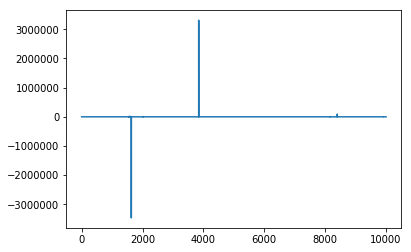

In [848]:
plt.plot(t.data[1].numpy())

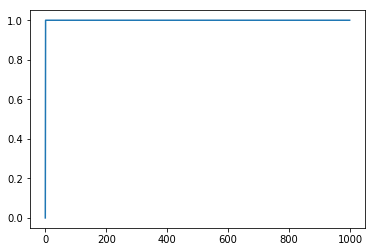

In [849]:
plt.plot(res)

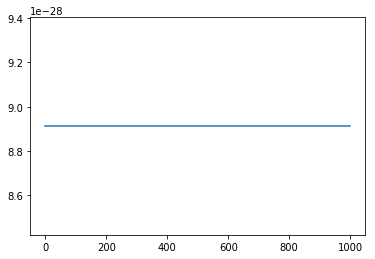

In [850]:
plt.plot(norms)

In [851]:
bleu(hard_t, r, f, 1)

Variable containing:
 1
[torch.FloatTensor of size 1]

In [852]:
(hard_t * r.data > 0).sum()

2

In [853]:
(hard_t * r.data > 0).sum()

2

In [842]:
torch.max(r, dim=1)[1]

Variable containing:
 2606
 6647
  799
[torch.LongTensor of size 3]

In [843]:
torch.max(hard_t, dim=1)[1]


 2606
 5489
 6647
[torch.LongTensor of size 3]

In [588]:
    overlap.backward()
    total_norm = t.grad.norm().data[0]
    last_el_grad = t.grad.data[0].numpy()[-1]
    ratio = last_el_grad / total_norm
    print('norm={},   last_el={},   ratio={},   temp={}'.format(total_norm, last_el_grad, ratio, temp))
# norms.append(t.grad.norm().data[0])
# plt.plot(norms)
# plt.show()

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [568]:
t.data[0].numpy()

array([  3.62997688e-02,  -1.66771650e+00,   1.31142914e+00, ...,
        -8.90833199e-01,   2.14474225e+06,   2.16324025e+06], dtype=float32)

In [569]:
t.data[1].numpy()

array([ -6.88916802e-01,   2.19479710e-01,  -2.57987827e-01, ...,
        -2.35618144e-01,   2.15968600e+06,  -1.64310202e-01], dtype=float32)

In [387]:
overlap_1

Variable containing:
 0.1565
 0.2245
[torch.FloatTensor of size 2]

In [418]:
total_norm

2.431659212158212e-40

In [314]:
x = Variable(torch.Tensor([1]), requires_grad=True)
y = Variable(torch.Tensor([2]), requires_grad=False)
z = x * y

w =  z * 5
z.register_hook(lambda grad: print(grad.norm()))
w.backward()
#print(w.grad)

Variable containing:
 5
[torch.FloatTensor of size 1]



In [417]:
(1e-5)**(1/30000)

0.9996163094458892

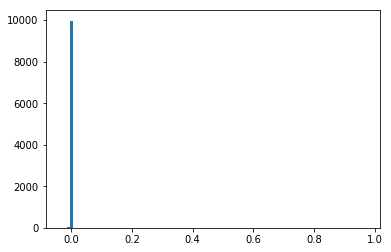

In [253]:
plt.hist(t.grad[0].data.numpy(), 100)
plt.show()

In [254]:
g = t.grad[0].data.numpy()

In [278]:
x.requires_grad = True